In [66]:
# ICS 438 Final Project:
# Jerome Gallego, Taylor Wong, Ujjwal Gautam
# December 13, 2022
#
# For this project we have decided to use a dataset made from yelp reviews. 
# Using the operation known as Sentiment Analysis, we can provide a detailed investigation on whether or not the star ratings
# -can reflect how positive, negative, or neutral each review is.

# In the yelp dataset, we will only be analyzing the star ratings and the reviews itself. Everything else can be considered irrelevant

#For this notebook please install these packages to ensure that the file is running correctly
#%pip install -U gensim
#%pip install nltk


# Import whatever libraries you would want to use
# Clean up cells to put all imports to the top

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# import gensim
# from gensim.parsing.preprocessing import remove_stopwords
# import re

In [60]:
## Before we can do any kind of analysis we will need to load the dataset.
# As instructed, we understand that loading a file into ram can seem inefficient,
# to overcome this obstacle we have decided to process the data using the batching method that we have learned from Mahdi.

## Process yelp.csv with chunk size of 50 and append it to the dataframe


df = pd.DataFrame()
with open('./data/yelp.csv', "r+") as csv_file:
    tp = pd.read_csv(csv_file, iterator=True, chunksize=50)
    df = pd.concat(tp, ignore_index=True) 
# df.shape
# df.head()
# df['type'].describe
# df.info


In [11]:
columns = df.columns.values.tolist()
print(columns)
df['text'][0]

['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']


'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [12]:
## To ensure we have removed all the irrelevant columns, we used the function drop() which will tell
## the dataframe to only include the stars and the text review. 
df.drop(labels=["business_id", "date", "type", "review_id", "user_id", "cool", "useful", "funny"], axis=1, inplace=True)
df

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...
...,...,...
9995,3,First visit...Had lunch here today - used my G...
9996,4,Should be called house of deliciousness!\n\nI ...
9997,4,I recently visited Olive and Ivy for business ...
9998,2,My nephew just moved to Scottsdale recently so...


In [13]:
## Cleaning the data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import string
def clean_data(data):
    x = data.lower()
    x = x.replace('\n','')
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    x = x.translate(table)
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
##apply clean_data function to the df["text"] column to remove punctuations, new lines, and stop words
df["text"] = df["text"].apply(clean_data)
df

,stars,text
0,5,wife took birthday breakfast excellent weathe...
1,5,idea people give bad reviews place goes show p...
2,4,love gyro plate rice good also dig candy selec...
3,5,rosie dakota love chaparral dog park convenien...
4,5,general manager scott petello good egg go deta...
...,...,...
9995,3,first visithad lunch today used groupon orde...
9996,4,called house deliciousnessi could go item item...
9997,4,recently visited olive ivy business last week ...
9998,2,nephew moved scottsdale recently bunch friends...


In [15]:
# As you can see there are 10000 entries in the file. By using Pandas Dataframe, it is good to know that we will not be able to
# -completely store all the data in RAM. With that being said to make it seem more realistic, we will cut down the dataframe
# -to have only 1000 randomly selected reviews. 
# Again, in some situations that can be too much for a machine to handle. To prevent any crashes or errors, we will be
# -batching the reviews in a set of 50 at a time.
# Thanks to the help of Assignment 2, we understand how to batch a set.

In [16]:
# Using sample() will randomly select 1000 reviews for analysis
df = df.sample(n=1000)
df

,stars,text
5990,3,mucho taco falls closer 25 starsaverage price...
2725,1,heard many good reviews place wouldnt try take...
1711,5,shaved ice bahama bucks reminds us vacationing...
2750,4,good food able manage large group easily party...
4582,1,really disappointed local baja fresh tonight ...
...,...,...
7816,4,get call thursday dude got fired uop celebrate...
6288,4,one favorite spot grab clothes gym work like s...
2944,5,kindred spirits closed doors sad thing west si...
2264,4,appears service kinks worked server attentive ...


In [17]:
# After we have cleaned the data to remove any sort of stop words and characters, we can start to implement the Sentiment Analysis.
# The main goal for this is produce a score from 0 to 1 whether it is categorized as Positive, Negative, or Neutral.

### Vader lexicon
Vader lexicon is a rule-based sentiment analysis tool specifically made for social media sentiment. For a more in-depth documentation please refer to their GitHub: https://github.com/cjhutto/vaderSentiment

### Why we chose vader lexicon
We decided to go with vader lexicon since the way vader lexicon was designed is meant for review analysis. On their GitHub page, examples of the training data used include 'The service here is extremely good', and 'The service here is good'. 

In [18]:
nltk.download('vader_lexicon') #WE NEED TO EXPLAIN WHAT THIS IS
from nltk.sentiment.vader import SentimentIntensityAnalyzer #WE NEED TO EXPLAIN WHAT THIS IS ALSO

for index, row in df['text'].iteritems():
    result = SentimentIntensityAnalyzer().polarity_scores(row)
    # if index%50 == 0:
    if result['neg'] > result['pos']:
        df.loc[index, "Sentiment"] = "negative"
    elif result['pos'] > result['neg']:
        df.loc[index, "Sentiment"] = "positive"
    else:
        df.loc[index, "Sentiment"] = "neutral"
        
    df.loc[index, 'neg'] = result['neg']
    df.loc[index, 'neu'] = result['neu']
    df.loc[index, 'pos'] = result['pos']
    df.loc[index, 'compound'] = result['compound']
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
/tmp/ipykernel_52/3360358221.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in df['text'].iteritems():


,stars,text,Sentiment,neg,neu,pos,compound
5990,3,mucho taco falls closer 25 starsaverage price...,positive,0.048,0.691,0.261,0.9169
2725,1,heard many good reviews place wouldnt try take...,positive,0.126,0.665,0.209,0.9060
1711,5,shaved ice bahama bucks reminds us vacationing...,positive,0.000,0.823,0.177,0.6249
2750,4,good food able manage large group easily party...,positive,0.000,0.733,0.267,0.7906
4582,1,really disappointed local baja fresh tonight ...,positive,0.169,0.536,0.295,0.4033
...,...,...,...,...,...,...,...
7816,4,get call thursday dude got fired uop celebrate...,positive,0.097,0.523,0.380,0.9958
6288,4,one favorite spot grab clothes gym work like s...,positive,0.000,0.568,0.432,0.9601
2944,5,kindred spirits closed doors sad thing west si...,negative,0.254,0.607,0.139,-0.6353
2264,4,appears service kinks worked server attentive ...,positive,0.066,0.581,0.353,0.9725


In [32]:
low_rate = df[(df['stars'] == 1) | (df['stars'] == 2)]
low_rate

,stars,text,Sentiment,neg,neu,pos,compound
2725,1,heard many good reviews place wouldnt try take...,positive,0.126,0.665,0.209,0.9060
4582,1,really disappointed local baja fresh tonight ...,positive,0.169,0.536,0.295,0.4033
1492,2,agree others cheap sushi option wasnt impress...,positive,0.084,0.635,0.281,0.8537
4704,2,review based strictly burgers whyi downloaded...,positive,0.012,0.813,0.176,0.9777
9421,1,cheap cheap beware order chicken mcnuggets ...,negative,0.113,0.809,0.078,-0.2960
...,...,...,...,...,...,...,...
9833,1,significant 25 coupon restaurantcom lol could ...,positive,0.018,0.757,0.224,0.9846
7916,2,service great like fox concepts pay much medio...,positive,0.161,0.429,0.410,0.8834
8851,2,wanting try sals quite never got around today...,positive,0.163,0.532,0.304,0.7506
3035,1,past three months ive receiving unsolicited sp...,negative,0.265,0.584,0.151,-0.6369


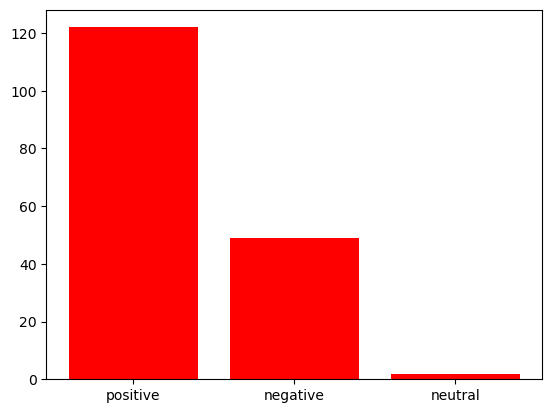

In [76]:
# bar chart showing total spread of sentiment
low_key = low_rate['Sentiment'].value_counts().keys().tolist()
low_val = low_rate['Sentiment'].value_counts().tolist()

fig = plt.bar(low_key, low_val, color='r')

([<matplotlib.patches.Wedge at 0x7f0fd91c45b0>,
 [Text(-0.6610147007427692, 0.8792380595731439, 'positive'),
  Text(0.6285411643141959, -0.9027380598836825, 'negative'),
  Text(1.0992696392092896, -0.04007817751193695, 'neutral')],
 [Text(-0.3605534731324196, 0.4795843961308057, '70.52%'),
  Text(0.34284063508047047, -0.49240257811837224, '28.32%'),
  Text(0.5996016213868852, -0.021860824097420153, '1.16%')])

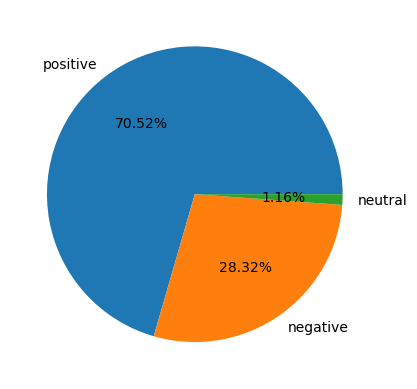

In [98]:
# normalize values to get %
norm_Lval = low_rate['Sentiment'].value_counts(normalize=True).tolist()
norm_Lvals = [i * 100 for i in norm_Lval]
for ind, i in enumerate(norm_Lvals):
    norm_Lvals[ind] = round(norm_Lvals[ind],2)
plt.pie(norm_Lvals, labels=low_key, autopct='%1.2f%%')

In [38]:
high_rate = df[(df['stars'] == 4) | (df['stars'] == 5)]
high_rate

,stars,text,Sentiment,neg,neu,pos,compound
1711,5,shaved ice bahama bucks reminds us vacationing...,positive,0.000,0.823,0.177,0.6249
2750,4,good food able manage large group easily party...,positive,0.000,0.733,0.267,0.7906
2399,4,went party 10 past weekend best friends birthd...,positive,0.069,0.520,0.411,0.9932
6532,5,new favorite place love pizza became vegetar...,positive,0.000,0.598,0.402,0.9810
8981,4,go place called fajitas order dang namesake iv...,positive,0.023,0.559,0.418,0.9890
...,...,...,...,...,...,...,...
8711,5,im pretty sure palees crown best thai place ev...,positive,0.029,0.557,0.413,0.9908
7816,4,get call thursday dude got fired uop celebrate...,positive,0.097,0.523,0.380,0.9958
6288,4,one favorite spot grab clothes gym work like s...,positive,0.000,0.568,0.432,0.9601
2944,5,kindred spirits closed doors sad thing west si...,negative,0.254,0.607,0.139,-0.6353


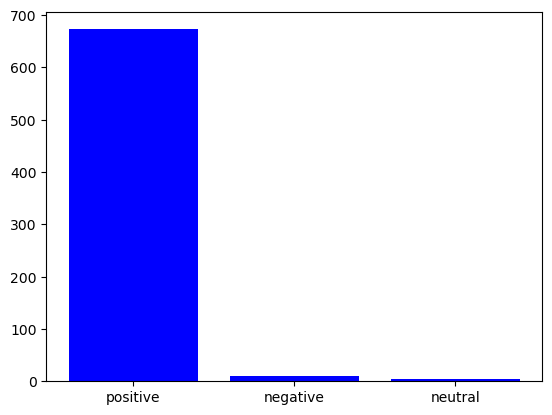

In [95]:
# bar chart showing total spread of sentiment
high_key = high_rate['Sentiment'].value_counts().keys().tolist()
high_val = high_rate['Sentiment'].value_counts().tolist()

fig = plt.bar(high_key, high_val, color='b')

([<matplotlib.patches.Wedge at 0x7f0fd916d1b0>,
 [Text(-1.0974212755973727, 0.07527644961231458, 'positive'),
  Text(1.0958675528788842, -0.09525915466371851, 'negative'),
  Text(1.0998174000405496, -0.020042119849098934, 'neutral')],
 [Text(-0.5985934230531124, 0.04105988160671704, '97.82%'),
  Text(0.5977459379339367, -0.05195953890748282, '1.60%'),
  Text(0.599900400022118, -0.01093206537223578, '0.58%')])

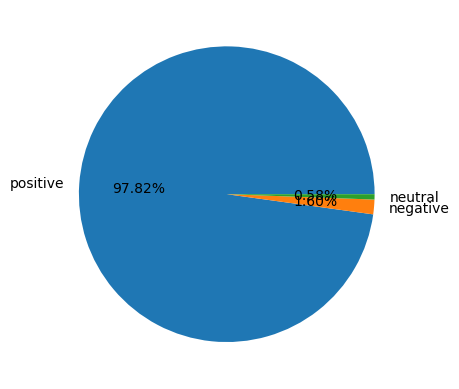

In [97]:
# normalize values to get %
norm_bval = high_rate['Sentiment'].value_counts(normalize=True).tolist()
norm_bvals = [i * 100 for i in norm_bval]
for ind, i in enumerate(norm_bvals):
    norm_bvals[ind] = round(norm_bvals[ind],2)
plt.pie(norm_bvals, labels=high_key, autopct='%1.2f%%')

In [21]:
neutral = df[(df['stars'] == 3)]
neutral

,stars,text,Sentiment,neg,neu,pos,compound
5990,3,mucho taco falls closer 25 starsaverage price...,positive,0.048,0.691,0.261,0.9169
838,3,somehow attempting write update original incre...,positive,0.144,0.647,0.209,0.8724
3783,3,service sucks waitress took forever get food ...,positive,0.105,0.758,0.137,0.4878
9629,3,taqueria latino supermarket nothing special c...,positive,0.095,0.800,0.105,0.0624
7195,3,wings buffalo arent usually breaded cant stand...,positive,0.000,0.816,0.184,0.6369
...,...,...,...,...,...,...,...
6216,3,yard house seems good place meet group people ...,positive,0.060,0.738,0.202,0.9689
5045,3,michael c right place charming love inside dec...,positive,0.119,0.691,0.190,0.9754
7161,3,chain restaurant thats okay afternoon dining f...,positive,0.063,0.796,0.141,0.8340
7136,3,refreshing find oneofakind places god knows p...,positive,0.027,0.815,0.158,0.9826


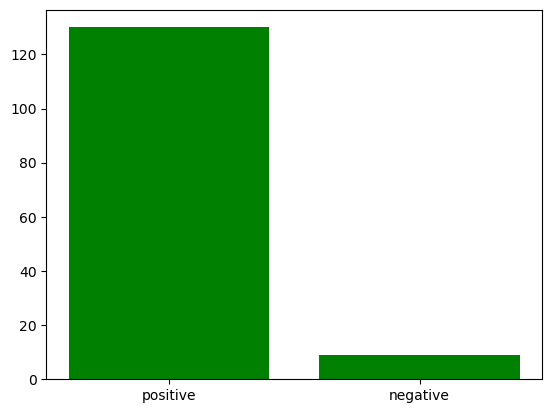

In [100]:
# bar chart showing total spread of sentiment
neu_key = neutral['Sentiment'].value_counts().keys().tolist()
neu_val = neutral['Sentiment'].value_counts().tolist()

fig = plt.bar(neu_key, neu_val, color='g')

([<matplotlib.patches.Wedge at 0x7f0fd8f10430>,
 [Text(-1.0773548428443998, 0.2220507658165564, 'positive'),
  Text(1.077354837646926, -0.22205079103386674, 'negative')],
 [Text(-0.5876480960969452, 0.12111859953630347, '93.53%'),
  Text(0.5876480932619595, -0.12111861329120002, '6.47%')])

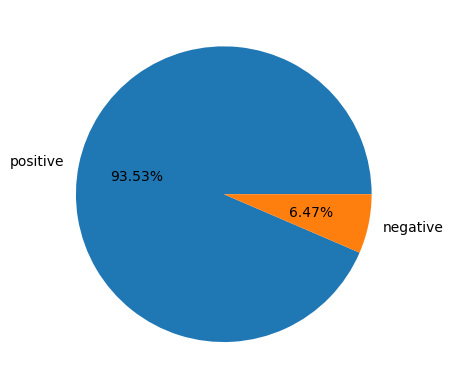

In [102]:
# normalize values to get %
norm_nval = neutral['Sentiment'].value_counts(normalize=True).tolist()
norm_nvals = [i * 100 for i in norm_nval]
for ind, i in enumerate(norm_nvals):
    norm_nvals[ind] = round(norm_nvals[ind],2)
plt.pie(norm_nvals, labels=neu_key, autopct='%1.2f%%')